<a href="https://colab.research.google.com/github/gopimandala/newdevops/blob/master/nlp_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# # Unzip the downloaded file - will have train.csv and test.csv files
import zipfile
zip_ref = zipfile.ZipFile("nlp_getting_started.zip", "r")  
zip_ref.extractall()
zip_ref.close()

--2022-03-30 10:20:57--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 173.194.216.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.4’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2022-03-30 10:20:57 (151 MB/s) - ‘nlp_getting_started.zip.4’ saved [607343/607343]



In [2]:
import os
# os.listdir('./')

In [3]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
print(train_df_shuffled.head(2))
# How many examples of each class?
print("\n",train_df.target.value_counts())

        id      keyword location  \
2644  3796  destruction      NaN   
2227  3185       deluge      NaN   

                                                   text  target  
2644  So you have a new weapon that can cause un-ima...       1  
2227  The f$&amp;@ing things I do for #GISHWHES Just...       0  

 0    4342
1    3271
Name: target, dtype: int64


In [5]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [7]:
# Since the test set has no labels and we need a way to evalaute our trained models, we'll split off some of the training data and create a validation set.
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [8]:
# View the first 10 training sentences and their labels
train_sentences[:2], train_labels[:2]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma'], dtype=object),
 array([0, 0]))

In [27]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

tf.keras.backend.clear_session()

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")
# Create model using the Sequential API
model = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  Dense(64, activation="relu"),
  Dropout(rate=0.5),
  Dense(32, activation="relu"),
  Dropout(rate=0.5),
  Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


filepath='./my_nlp_model.h5'
modelcheckpoint = ModelCheckpoint(filepath=filepath, save_best_only=True)


reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              patience=5, 
                              min_delta=0.005,
                              mode='min',
                              min_lr=0.0001)

earlystopping = EarlyStopping(monitor='val_accuracy',
                             min_delta=0.0001,
                             patience=10)

callbacks = [modelcheckpoint,reduce_lr,earlystopping]

model.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 256,832,769
Trainable params: 34,945
Non-

In [28]:
# Train a classifier on top of pretrained embeddings
history = model.fit(train_sentences,
                    train_labels,
                    epochs=50,
                    validation_data=(val_sentences, val_labels), callbacks=callbacks)

Epoch 1/50
215/215 [==============================] - 11s 40ms/step - loss: 0.5557 - accuracy: 0.7330 - val_loss: 0.4470 - val_accuracy: 0.8005 - lr: 0.0010
Epoch 2/50
215/215 [==============================] - 8s 37ms/step - loss: 0.4460 - accuracy: 0.8116 - val_loss: 0.4386 - val_accuracy: 0.7992 - lr: 0.0010
Epoch 3/50
215/215 [==============================] - 8s 35ms/step - loss: 0.4216 - accuracy: 0.8232 - val_loss: 0.4266 - val_accuracy: 0.8176 - lr: 0.0010
Epoch 4/50
215/215 [==============================] - 3s 16ms/step - loss: 0.4072 - accuracy: 0.8266 - val_loss: 0.4280 - val_accuracy: 0.8097 - lr: 0.0010
Epoch 5/50
215/215 [==============================] - 8s 37ms/step - loss: 0.3997 - accuracy: 0.8335 - val_loss: 0.4250 - val_accuracy: 0.8163 - lr: 0.0010
Epoch 6/50
215/215 [==============================] - 8s 37ms/step - loss: 0.3948 - accuracy: 0.8354 - val_loss: 0.4229 - val_accuracy: 0.8150 - lr: 0.0010
Epoch 7/50
215/215 [==============================] - 4s 18ms/s

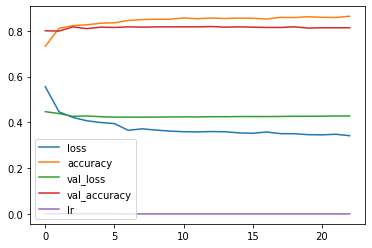

In [29]:
import pandas as pd
pd.DataFrame(history.history).plot()

In [12]:
bestmodel = tf.keras.models.load_model((filepath),custom_objects={'KerasLayer':hub.KerasLayer})
newpred = bestmodel.predict(val_sentences)

In [22]:
# Make predictions with USE TF Hub model
model_6_pred_probs = bestmodel.predict(val_sentences)
model_6_pred_probs[21:31]

array([[0.15397957],
       [0.39009336],
       [0.01272896],
       [0.85781354],
       [0.976964  ],
       [0.04891753],
       [0.09837723],
       [0.14739123],
       [0.2477386 ],
       [0.4672109 ]], dtype=float32)

In [26]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[21:31]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 1., 1., 0., 0., 0., 0., 0.], dtype=float32)>

In [23]:
val_labels[21:31], val_sentences[21:31]

(array([1, 1, 1, 1, 1, 0, 0, 0, 0, 1]),
 array(['So I pick myself off the ground and swam before I drowned. Hit the bottom so hard I bounced twice suffice this time around is different.',
        "US wont upgrade its infrastructure? http://t.co/NGEHhG9YGa' it a bad situation and its going to get ugly very quickly #USA #sustainability",
        "Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube",
        "New warning for Central Hills 1' hail 60 mph winds. NOT affecting Sturgis but could later tonight. #KOTAWeather http://t.co/qo3VWFelkp",
        '70 Years After Atomic Bombs Japan Still Struggles With War Past: The anniversary of the devastation wrought b... http://t.co/iTBJ6DKRZI',
        "If I survive I'll see you tomorrow",
        'Bit pacquiao vs marquez 3 unfilled blazing swarm online: DuRvOd http://t.co/6VJA8R4YXA',
        '@SeanPeconi @Jason_Floyd @LynchOnSports @criscyborg I think the risk of losing and getting her nose flattened has a lot to do w